<a href="https://colab.research.google.com/github/sperezconstanzo/DigitalHouse-DataScience-tp/blob/main/desafio_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="section_toc"></a> 

# Tabla de Contenidos

[0 - Imports y definiciones](#section_imports) <br>
[1 - Primer análisis del DataFrame y limpieza](#section_analisis) <br>
[2 - Modelado](#section_modelado) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 - MultinomialNB](#section_MultinomialNB) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 - CatBoostClassifier](#section_CatBoostClassifier) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 - RandomForestClassifier](#section_RandomForestClassifier) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.4 - MultinomialNB con otro subreddit](#section_MultinomialNB_2) <br>


<a id="section_imports"></a> 

## 0 - Imports y definiciones

[volver a TOC](#section_toc)

Para cargar los datasets y modelos de esta práctica necesitaremos acceso al directorio de Google Drive donde están los archivos `.csv` y `.pickle`. Podemos acceder usando el siguiente link: https://drive.google.com/drive/folders/1iY3GsJLbXRpc3sSojo-JxdO-59aEy2kd?usp=sharing

Una vez que tenemos acceso al directorio, tenemos que agregar un acceso directo de esta carpeta a nuestro Drive.

Finalmente, tenemos que montar el directorio de drive en Google Colab ejecutando el siguiente código y siguiendo las instrucciones:

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install catboost
!pip install unidecode
!pip install scikit-learn==0.23.1

     |████████████████████████████████| 67.4 MB 28 kB/s 
     |████████████████████████████████| 235 kB 5.2 MB/s 
     |████████████████████████████████| 6.8 MB 5.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from tqdm import tqdm
import re

from catboost import CatBoostClassifier

from multiprocessing import Pool
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
stopwords_en = stopwords.words('english')

import unidecode

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
# Esta función samplea estratificadamente, algo que el método pd.DataFrame.sample no soporta.
# Ojo que retorna nrows = n_samples * n_categorias, en nuestro caso, n_samples * 39

def stratified_sample_df(df, col, n_samples, random_state= None):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n, random_state= random_state))
    df_.index = df_.index.droplevel(0)
    return df_


def binary_sample(df, col, value, samples= None, random_state= None):
    """
    El df que retorna no esta shuffleado: las primeras n = n_samples filas co-
    rresponden a la clase que queremos true. Se puede lograr haciendo
    df.sample(frac= 1) pero no sé en este momento si hace falta o no, entonces
    no me caliento al respecto. No samplea estratificado porque---en nuestro
    caso al menos---para que quede balanceado tengo que tener
    `n_samples` % 39 == 0... en otras palabras, para que sea estratificado ne-
    cesariamente tengo que tomar una fila de cada clase (de las falsas), que
    son justamente 39. Entonces hago un sampleo común y listo.
    Lo perfecto es enemigo de lo bueno.
    
    Parametros
    ----------
    
    df : pd.DataFrame
    \tEl df del que vamos a samplear
    
    col : str
    \tLa columna target que queremos samplear
    
    value : str
    \tLa categoría que queremos clasificar como True. Si no está en df[col].unique()
    \traisea warning y retorna None
    
    samples : int, default None
    \tLa cantidad de muestras que quiero. El df final tendrá `samples` * 2 filas
    \tSi es None, `samples` es igual a la cantidad de filas de `value`
    \tSi es mayor a la cantidad de filas de `value`, raisea warning y se fija
    \tigual que en el caso `samples` = None
    
    random_state : int y otros, default 1
    \tPara reproducibilidad. Los otros tipos soportados pueden consultarse en la
    \tdocumentación de pd.DataFrame.sample
    """ 
    import warnings
    
    if value in df[col].unique():
 
        mask = df[col] == value
        mask_index = df[mask].index

        df_pos = df[mask].copy(deep= True)
        df_neg = df.drop(index= mask_index, inplace= False)
        
        max_samples = df_pos.shape[0]

        if samples == None:
            samples = max_samples

        elif samples > max_samples:
            warnings.warn(f'\nCannot take a larger sample than population. Samples was {samples} but is now set to {max_samples}')

        n = min(samples, max_samples)

        df_pos = df_pos.sample(n= n, random_state= random_state)
        df_neg = df_neg.sample(n= n, random_state= random_state)

        df_ = pd.concat([df_pos, df_neg]).reset_index(drop= True)
        
        return df_
    
    else:
        warnings.warn(f'\nValue {value} not in column {col}. No operation performed.')
        return None    

    
def tokenize(x, stopwords):
    tokens = word_tokenize(x)
    tokens_without_stopwords = [tok for tok in tokens if not (tok in stopwords)]
    string = ' '.join(tokens_without_stopwords)
    
    return string


# Matriz de confusión con los yticks centrados
def conf_mat(y_test, Y_pred, umbral=0.5):

    conf_mat = confusion_matrix(y_test, Y_pred)
    conf_mat_df = pd.DataFrame(data=conf_mat, 
                               index=['Actual Negative: 0', 'Actual Positive: 1'], 
                               columns=['Predict Negative: 0', 'Predict Positive: 1'])

    fig, ax = plt.subplots()
    ax = sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='YlGnBu', ax= ax)
    ax.set_title(f'Matriz de confusión. Umbral = {umbral}')
    ax.set_yticklabels(list(conf_mat_df.index), rotation=90, va="center");

<a id="section_analisis"></a>

## 1 - Primer análisis del DataFrame y limpieza

[volver a TOC](#section_toc)

Reddit, según wikipedia es "un sitio web de marcadores sociales y agregador de noticias donde los usuarios pueden añadir textos, imágenes, videos o enlaces. Los usuarios pueden votar a favor o en contra del contenido, haciendo que aparezcan en las publicaciones destacadas."

Podríamos describirlo en palabras más sencillas como un foro. Cada subforo se llama <em>subreddit</em>, y tratan tópicos muy diversos.

Este dataframe contiene un millón de comentarios de reddit, los cuales fueron tomados de manera uniforme de los 40 subreddits más populares en mayo del 2019; es decir tenemos 25 k comentarios por subreddit. Esto nos va a ser útil ya que vamos a partir de un set balanceado. Además ya está preprocesado: se han quitado los comentarios eliminados y aquellos que tengan menos de cuatro <em>tokens</em>, i.e. que sean demasiado cortos.

Las columnas son:

* <b>subreddit:</b> de qué subforo fue tomado el comentario,
* <b>body:</b> el cuerpo del comentario,
* <b>controversiality:</b> una métrica propia de reddit; son booleanos,
* <b>score:</b> un puntaje calculado como upvotes - downvotes.

Con esta base podemos realizar un modelo de clasificación en el que podamos predecir a qué subreddit pertenece un comentario.
Con la cantidad de features que tenemos podemos correr modelos, pero también hay lugar a generar más features.

In [5]:
data_path = "/content/drive/MyDrive/Desafio 3/Data/kaggle_RC_2019-05.csv"

data = pd.read_csv(data_path, encoding= 'utf-8')

In [6]:
nrow, ncol = data.shape

data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   subreddit         1000000 non-null  object
 1   body              1000000 non-null  object
 2   controversiality  1000000 non-null  int64 
 3   score             1000000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 30.5+ MB


In [7]:
data.sample(5)

,subreddit,body,controversiality,score
352717,unpopularopinion,"Every day, I've made a goal to do something. I...",0,2
535740,videos,"Hello /u/AriseFanBoy,\n\n/r/Videos requires th...",0,1
968838,Animemes,Ye she stabbed herself,0,2
638339,memes,"""hats of to the guy who did this""??, Then why ...",0,-10
201930,asoiaf,I'm hoping it'll be revealed that bran through...,0,1


Vimos que algunos comentarios no estaban en inglés, vamos a chequear que hay en cada subreddit. Para esto usamos un sampleo estratificado y tomamos un comentario de cada subreddit.

In [8]:
# Esto está para ver un comentario de cada subreddit para ver si están todos en inglés
# Spoiler alert: hay uno ruso.

data_aux = stratified_sample_df(data, 'subreddit', 1, random_state= 10)

for body, subreddit in zip(data_aux['body'], data_aux['subreddit']):
    print(subreddit)
    print(body)
    print('\u2014' * 80)

AmItheAsshole
Do you understand how ridiculous that sounds lol you literally just said the same thing
————————————————————————————————————————————————————————————————————————————————
Animemes
The virgin r/waterbros

The chad r/hydrohomies
————————————————————————————————————————————————————————————————————————————————
AskReddit
Chopping firewood. Feels good to hit shit and see it split.
————————————————————————————————————————————————————————————————————————————————
ChapoTrapHouse
folks folks ive been a bottom my whole life, but now i think that its about time for trump to switch things up what do you think about that folks

who wants to see trump on top folks?
————————————————————————————————————————————————————————————————————————————————
FortNiteBR
**Unfortunately, we've had to remove your post.**
___


### Post Flair Guidelines

We require all users to set a post flair for their own post. There is a 30 minute grace period, and this has passed for this post. 

Don't know how to flai

In [9]:
mask_pikabu = data['subreddit'] == 'Pikabu'
pikabu_index = data[mask_pikabu].index

data.iloc[pikabu_index, 0].value_counts()  # Chequeamos que hayamos capturado lo que queríamos

Pikabu    25000
Name: subreddit, dtype: int64

In [10]:
data = data.drop(index= pikabu_index).reset_index(drop= True)

Vimos que algunos comentarios comienzan con `&gt;`, que es un <em>entity name</em> de html para el caracter `>`. Dentro del contexto de foros y <em>message boards</em>, este símbolo se usa al comienzo de una línea de texto para indicar que ésta es una cita a otro comentario. Creemos que es accidental que ese grupo de caracteres haya llegado al dataset, no obstante vamos a aprovecharlo para crear una nueva feature. Aparte, vamos a usar regex para limpiar todos los saltos de línea que no fueron codificados correctamente (se muestra el comando unicode `\n`)

In [11]:
# Creamos una feature dummy que indica si el comentario incluye una cita/respuesta a otro.

pattern_html_gt = r'&gt;'
rx_html_gt = re.compile(pattern= pattern_html_gt, flags= re.IGNORECASE)

data['is_reply'] = 0

mask_reply = data['body'].apply(rx_html_gt.search).apply(bool)

data.loc[mask_reply, 'is_reply'] = 1

In [12]:
# Creamos una copia de la columna `body` para limpiarla, conservando la original.

data['body_clean'] = data['body'].copy(deep= True)

In [13]:
pattern_unicode_space = r'[\t\n\r\f\v(\xa0)]'  # Espacios unicode (tab, newline, nonbreaking, vtab, lf, cr)
rx_unicode_space = re.compile(pattern= pattern_unicode_space, flags= re.IGNORECASE)

pattern_url = r"http\S+"  # URLs, aunque hay que tener cuidado ya que tiene que haber un espacio al final de la url, sino captura texto también.
rx_url = re.compile(pattern= pattern_url, flags= re.ASCII)

pattern_html_symbol = r'&\w+;'  # Símbolos que están en formato html &..;
rx_html_symbol = re.compile(pattern= pattern_html_symbol, flags= re.ASCII)

pattern_punkt = r'([^\s\w]|_)+'  # Signos de puntuación
rx_punkt = re.compile(pattern= pattern_punkt, flags= re.IGNORECASE)

data['body_clean'] = data['body_clean'].apply(lambda x: re.sub(rx_unicode_space, ' ', x))  # Reemplazamos espacios unicode por ' '
data['body_clean'] = data['body_clean'].apply(lambda x: re.sub(rx_url, '', x))  # Quitamos URLs
data['body_clean'] = data['body_clean'].apply(lambda x: re.sub(rx_html_symbol, ' ', x))  # Quitamos símbolos HTML &..;
data['body_clean'] = data['body_clean'].apply(lambda x: re.sub(rx_punkt, ' ', x))  # Quitamos puntuación
data['body_clean'] = data['body_clean'].apply(lambda x: unidecode.unidecode(x.lower()))  # Quitamos tildes y pasamos a minusculas

In [14]:
# Tarda alrededor de 5' en correr

data['tokens'] = data['body_clean'].apply(lambda x : tokenize(x, stopwords_en))

In [15]:
#data.to_pickle('datos_limpios.pickle')

In [16]:
# Para evitar tener que tokenizar se puede descomentar esta celda y tomar el `.pickle` con los datos tokenizados
#data = pd.read_pickle('/content/drive/MyDrive/Desafio 3/pickle/datos_limpios.pickle')

In [17]:
# Creamos una feature: largo del comentario (sólo contando tokens)

data['body_len'] = data['tokens'].apply(lambda x : len(x.split()))

In [18]:
data.sample(10)

,subreddit,body,controversiality,score,is_reply,body_clean,tokens,body_len
104670,freefolk,Compared to what we heard about last time it w...,0,1,0,compared to what we heard about last time it w...,compared heard last time pretty big failure un...,14
30179,nba,Up 5 with Kyrie playing like dog shit. I'll ta...,0,6,0,up 5 with kyrie playing like dog shit i ll ta...,5 kyrie playing like dog shit take,7
167787,nba,&gt;durant's proportions are like those girls ...,0,2,1,durant s proportions are like those girls in ...,durant proportions like girls 6th grade get wa...,12
52740,nba,I feel like Bucks are just 2017 Rockets. Live ...,0,1,0,i feel like bucks are just 2017 rockets live ...,feel like bucks 2017 rockets live die 3,8
380454,FortNiteBR,I still enjoy the game but i dont like the dir...,0,7,0,i still enjoy the game but i dont like the dir...,still enjoy game dont like direction epic taking,8
520915,pics,Some other [stars who are around 50.](https://...,0,94,0,some other stars who are around 50 i woul...,stars around 50 would say even among famous pe...,20
390714,gaming,Asset swaps? It's a different car.. Different ...,0,-12,0,asset swaps it s a different car different s...,asset swaps different car different scenary di...,9
111749,apexlegends,I have been wondering about this today too.. I...,0,1,0,i have been wondering about this today too i ...,wondering today pretty sure updated,5
558467,dankmemes,"It's dying in new, you have lied to me",0,1,0,it s dying in new you have lied to me,dying new lied,3
458265,Showerthoughts,"""I'm going outside for a minute, I need a smok...",0,6,0,i m going outside for a minute i need a smok...,going outside minute need smoke fuck week need...,9


In [19]:
data_q90 = data[data['body_len'] < data['body_len'].quantile(0.90)]

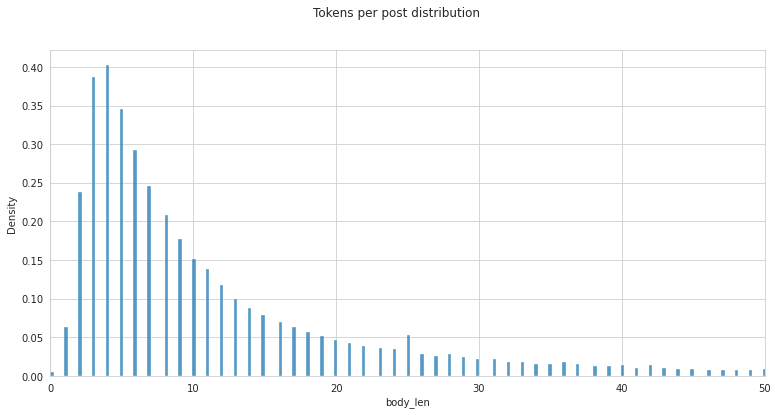

In [20]:
fig, ax = plt.subplots(figsize=(12.8, 6))
fig.suptitle('Tokens per post distribution');
ax.set_xlim(0, 50)  # La proporción de posts con >50 tokens es baja y la ignoramos para más visibilidad
sns.histplot(ax=ax, data=data['body_len'], legend=False, stat='density');

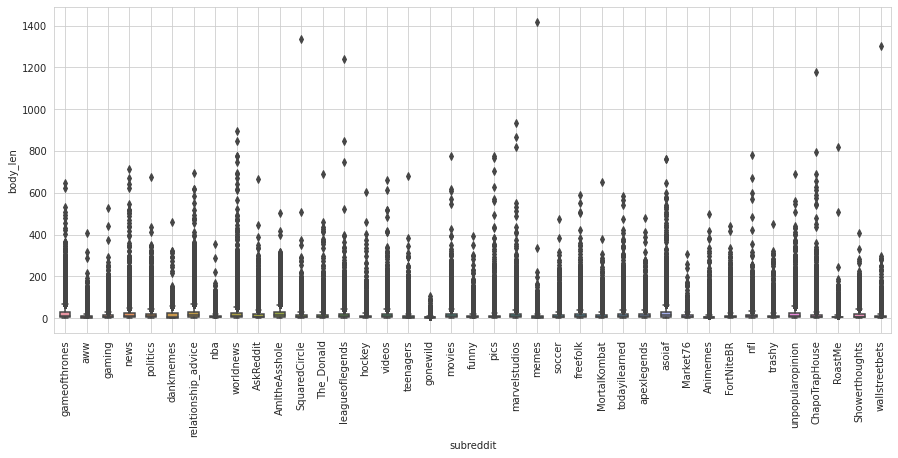

In [21]:
plt.figure(figsize=(15,6))
sns.boxplot(data=data, x='subreddit', y='body_len', width=0.5, orient= "v");
plt.xticks(rotation=90)
plt.grid(True)

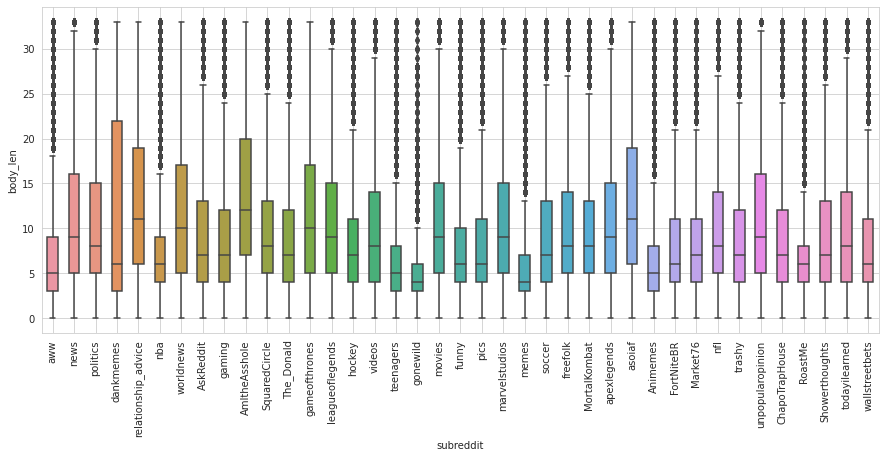

In [22]:
# No nos sirve ver el dataset entero, vamos a mirar el 90% inferior
plt.figure(figsize=(15,6))
sns.boxplot(data=data_q90, x='subreddit', y='body_len', width=0.5, orient= "v");
plt.xticks(rotation=90)
plt.grid(True)

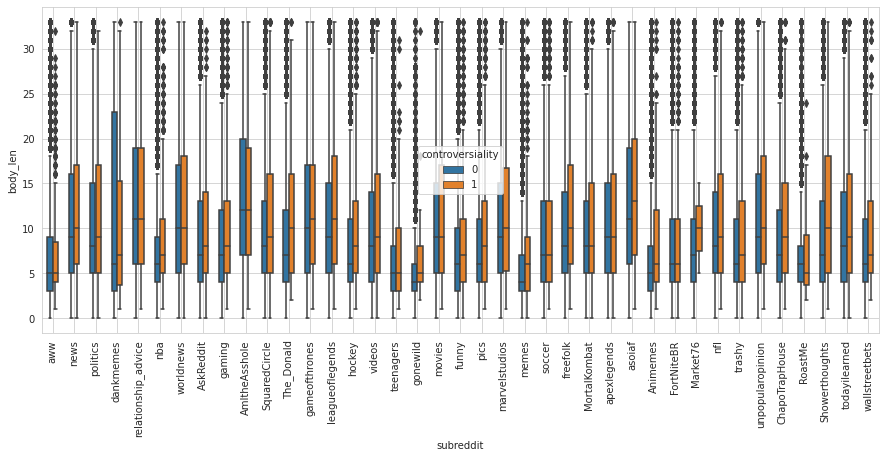

In [23]:
# Buscamos ver si hay alguna relacion en la longitud de los comentarios y la controversialidad
plt.figure(figsize=(15,6))
sns.boxplot(data=data_q90, x='subreddit', y='body_len', width=0.5, orient= "v", hue= "controversiality");
plt.xticks(rotation=90)
plt.grid(True)

<a id="section_modelado"></a>

## 2 - Modelado

[volver a TOC](#section_toc)

Como el modelo que queremos crear es muy intenso en recursos (1 M filas, 39 categorías), vamos a clasificar binariamente si un comentario pertenece o no a un subreddit. Para esto vamos a elegir un subreddit y samplear 25 k comentarios de los otros 38. Sobre esta base vamos a correr todos los modelos. Sobre el final, vamos a probar el mismo modelo pero con otro subreddit a ver qué ocurre.

In [24]:
data_sample = binary_sample(data, 'subreddit', 'Market76', random_state=42)
data_sample['class'] = 0
mask = data_sample['subreddit'] == 'Market76'
data_sample.loc[mask, 'class'] = 1

In [25]:
data_sample.sample(5)

,subreddit,body,controversiality,score,is_reply,body_clean,tokens,body_len,class
42539,AmItheAsshole,Not a problem if you're an only child and your...,0,1,0,not a problem if you re an only child and your...,problem child parents tend intrusive using bat...,16,0
49587,aww,I actually had this happen to me. I thought my...,0,2,0,i actually had this happen to me i thought my...,actually happen thought cat female found stree...,52,0
38276,trashy,Yes. If they're still alive. A lot of times yo...,0,161,0,yes if they re still alive a lot of times yo...,yes still alive lot times young animals taken ...,17,0
17977,Market76,You could have stayed in party. Just doing a q...,0,1,0,you could have stayed in party just doing a q...,could stayed party quick trade,5,1
37722,videos,"He has a really high IQ.\n\n\nBut fr, I rememb...",0,12,0,he has a really high iq but fr i remember ...,really high iq fr remember reading theories re...,17,0


Aquí separamos en train y test, usamos como predictora el cuerpo crudo de los mensajes. Por razones de tiempo no llegamos a probar modelos con la versión tokenizada por `nltk` para estudiar diferencias entre el preprocesado de `sklearn` que incluímos en el pipeline y el que hicimos antes. Igualmente sirvió como entrenamiento para usar la herramienta `nltk`

In [26]:
X = data_sample["body"]
y = data_sample["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(37500,)
(12500,)
(37500,)
(12500,)


<a id="section_MultinomialNB"></a>

### 2.1 - MultinomialNB

[volver a TOC](#section_toc)

In [27]:
# Esta instancia de pipeline será usada a lo largo de los modelos.

pipe_1_steps = [('preprocesamiento', TfidfVectorizer()),
                ('clf', MultinomialNB())]

pipe_1 = Pipeline(pipe_1_steps)

In [28]:
folds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

param_grid_1 = {'preprocesamiento' : [TfidfVectorizer(), CountVectorizer()],
                'preprocesamiento__stop_words': ['None', 'english'],  #con o sin stopwords
                'preprocesamiento__max_df': np.logspace(-2, 0, num= 10),  #elimina términos con frecuencia mayor al valor dado
                'preprocesamiento__min_df': np.logspace(-12, -10, num= 10), #elimina términos con frecuencia menor al valor dado
                'preprocesamiento__ngram_range': [(1,1),(1,2)], #genera n-gramas
                }

grid_1 = GridSearchCV(pipe_1, param_grid_1, cv= folds, verbose= 10, scoring= 'accuracy', n_jobs= -1)

In [29]:
# Aprox 30' sobre 2400 fits (3 folds, 800 combinaciones de hiperparámetros)
grid_1.fit(X_train, y_train)

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocesamiento', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'preprocesamiento': [TfidfVectorizer(max_df=0.0774263682681127,
                                                              min_df=1e-12,
                                                              ngram_range=(1,
                                                                           2),
                                                              stop_words='english'),
                                              CountVectorizer()],
                         'preprocesamiento__max_df': arr...
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ]),
                         'preprocesamiento__min_df': array([1.00000000e-12, 1.66810054e-12, 2.78255940e-12, 4.64158883e-12,
       7.74263683e-12, 1.29

In [30]:
#modelo1_filename = 'multinomialNB_25k.pickle'
#pickle.dump(grid_1, open(modelo1_filename, 'wb'))

In [31]:
#grid_1 = pickle.load(open('/content/drive/MyDrive/Desafio 3/pickle/multinomialNB_25k.pickle', 'rb'))

In [32]:
print(grid_1.best_params_)
print(grid_1.best_score_)

{'preprocesamiento': TfidfVectorizer(max_df=0.0774263682681127, min_df=1e-12, ngram_range=(1, 2),
                stop_words='english'), 'preprocesamiento__max_df': 0.0774263682681127, 'preprocesamiento__min_df': 1e-12, 'preprocesamiento__ngram_range': (1, 2), 'preprocesamiento__stop_words': 'english'}
0.9337866666666667


In [33]:
y_pred = grid_1.predict(X_test)
accuracy_score(y_test, y_pred)

0.93888

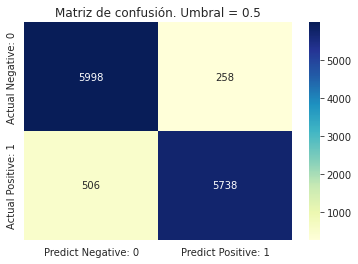

In [34]:
conf_mat(y_test, y_pred)

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      6256
           1       0.96      0.92      0.94      6244

    accuracy                           0.94     12500
   macro avg       0.94      0.94      0.94     12500
weighted avg       0.94      0.94      0.94     12500



In [36]:
# Guardamos esto para más adelante
best_params_grid_1 = grid_1.best_params_

<a id="section_CatBoostClassifier"></a>

### 2.2 - CatBoostClassifier

[volver a TOC](#section_toc)

In [37]:
folds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

param_grid_2 = {
     'preprocesamiento__stop_words': [best_params_grid_1['preprocesamiento__stop_words']], 
     'preprocesamiento__max_df': [best_params_grid_1['preprocesamiento__max_df']],  
     'preprocesamiento__min_df': [best_params_grid_1['preprocesamiento__min_df']], 
     'preprocesamiento__ngram_range': [best_params_grid_1['preprocesamiento__ngram_range']],
     'clf': [CatBoostClassifier()],
     'clf__task_type': ['CPU'],
     'clf__boosting_type': ['Plain'],
     'clf__max_ctr_complexity': [1],
     'clf__gpu_cat_features_storage': ['CpuPinnedMemory']
    }

grid_2 = GridSearchCV(pipe_1, param_grid_2, cv=folds, verbose=10, scoring='accuracy', n_jobs=-1)

In [38]:
# Alrededor de 1h para los fits + 30' para learn; 3 fits (3 folds, 1 set de hiperparámetros)
grid_2.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 59.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 59.1min finished


Learning rate set to 0.048422
0:	learn: 0.6614220	total: 2.5s	remaining: 41m 33s
1:	learn: 0.6410293	total: 4.15s	remaining: 34m 32s
2:	learn: 0.6222412	total: 5.7s	remaining: 31m 35s
3:	learn: 0.6051213	total: 7.11s	remaining: 29m 31s
4:	learn: 0.5929132	total: 8.49s	remaining: 28m 9s
5:	learn: 0.5845091	total: 9.87s	remaining: 27m 14s
6:	learn: 0.5770831	total: 11.4s	remaining: 26m 51s
7:	learn: 0.5706134	total: 13s	remaining: 26m 55s
8:	learn: 0.5638062	total: 14.7s	remaining: 27m 2s
9:	learn: 0.5570521	total: 16.4s	remaining: 27m 6s
10:	learn: 0.5491049	total: 18.1s	remaining: 27m 7s
11:	learn: 0.5454493	total: 19.7s	remaining: 27m 4s
12:	learn: 0.5403909	total: 21.4s	remaining: 27m 7s
13:	learn: 0.5348131	total: 23.1s	remaining: 27m 6s
14:	learn: 0.5304781	total: 24.7s	remaining: 27m 5s
15:	learn: 0.5265216	total: 26.6s	remaining: 27m 14s
16:	learn: 0.5218721	total: 28.3s	remaining: 27m 15s
17:	learn: 0.5184608	total: 30s	remaining: 27m 14s
18:	learn: 0.5152965	total: 31.6s	remain

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocesamiento', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf': [<catboost.core.CatBoostClassifier object at 0x7f26b48b1410>],
                         'clf__boosting_type': ['Plain'],
                         'clf__gpu_cat_features_storage': ['CpuPinnedMemory'],
                         'clf__max_ctr_complexity': [1],
                         'clf__task_type': ['CPU'],
                         'preprocesamiento__max_df': [0.0774263682681127],
                         'preprocesamiento__min_df': [1e-12],
                         'preprocesamiento__ngram_range': [(1, 2)],
                         'preprocesamiento__stop_words': ['english']},
             scoring='accuracy', verbose=10)

In [39]:
#modelo2_filename = 'CBClassifier_25k.pickle'
#pickle.dump(grid_2, open(modelo2_filename, 'wb'))

In [40]:
#grid_2 = pickle.load(open('/content/drive/MyDrive/Desafio 3/pickle/CBClassifier_25k.pickle', 'rb'))

In [41]:
print(grid_2.best_params_)
print(grid_2.best_score_)

{'clf': <catboost.core.CatBoostClassifier object at 0x7f26b48b1410>, 'clf__boosting_type': 'Plain', 'clf__gpu_cat_features_storage': 'CpuPinnedMemory', 'clf__max_ctr_complexity': 1, 'clf__task_type': 'CPU', 'preprocesamiento__max_df': 0.0774263682681127, 'preprocesamiento__min_df': 1e-12, 'preprocesamiento__ngram_range': (1, 2), 'preprocesamiento__stop_words': 'english'}
0.9002133333333333


In [42]:
y_pred = grid_2.predict(X_test)
accuracy_score(y_test, y_pred)

0.90928

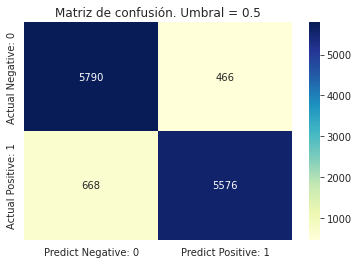

In [43]:
conf_mat(y_test, y_pred)

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      6256
           1       0.92      0.89      0.91      6244

    accuracy                           0.91     12500
   macro avg       0.91      0.91      0.91     12500
weighted avg       0.91      0.91      0.91     12500



<a id="section_RandomForestClassifier"></a>

### 2.3 - RandomForestClassifier

[volver a TOC](#section_toc)

In [45]:
folds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

param_grid_3 = {'preprocesamiento' : [TfidfVectorizer(), CountVectorizer()],
                 'preprocesamiento__stop_words': ['None', 'english'],  #con o sin stopwords
                 'preprocesamiento__max_df': np.logspace(-2, 0, num= 5),  #elimina términos con frecuencia mayor al valor dado
                 'preprocesamiento__min_df': np.logspace(-11, -8, num= 5), #elimina términos con frecuencia menor al valor dado
                 'preprocesamiento__ngram_range': [(1,1),(1,2)], #genera n-gramas
                 'clf': [RandomForestClassifier()],
                 'clf__max_depth': [3, 4, 5]  # Sin limitar el numero de árboles tardaba días en correr
                }


grid_3 = GridSearchCV(pipe_1, param_grid_3, cv=folds, verbose=10, scoring='accuracy', n_jobs=-1)

In [46]:
# Aprox 30' para 1800 fits (3 folds, 600 combinaciones de hiperparámetros)
grid_3.fit(X_train, y_train)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  2

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocesamiento', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf': [RandomForestClassifier(max_depth=5)],
                         'clf__max_depth': [3, 4, 5],
                         'preprocesamiento': [TfidfVectorizer(max_df=0.03162277660168379,
                                                              min_df=1.7782794100389228e-09,
                                                              stop_words='english'),
                                              CountVectorizer()],
                         'preprocesamiento__max_df': array([0.01      , 0.03162278, 0.1       , 0.31622777, 1.        ]),
                         'preprocesamiento__min_df': array([1.00000000e-11, 5.62341325e-11, 3.16227766e-10, 1.77827941e-09,
       1.00000000e-08]),
                       

In [47]:
#modelo3_filename = 'RndForestClassifier_25k.pickle'
#pickle.dump(grid_3, open(modelo3_filename, 'wb'))

In [48]:
#grid_3 = pickle.load(open('/content/drive/MyDrive/Desafio 3/pickle/RndForestClassifier_25k.pickle', 'rb'))

In [49]:
print(grid_3.best_params_)
print(grid_3.best_score_)

{'clf': RandomForestClassifier(max_depth=5), 'clf__max_depth': 5, 'preprocesamiento': TfidfVectorizer(max_df=0.03162277660168379, min_df=1.7782794100389228e-09,
                stop_words='english'), 'preprocesamiento__max_df': 0.03162277660168379, 'preprocesamiento__min_df': 1.7782794100389228e-09, 'preprocesamiento__ngram_range': (1, 1), 'preprocesamiento__stop_words': 'english'}
0.7784


In [50]:
y_pred = grid_3.predict(X_test)
accuracy_score(y_test, y_pred)

0.77104

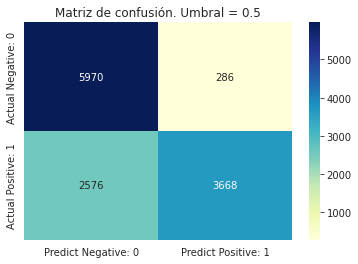

In [51]:
conf_mat(y_test, y_pred)

In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.95      0.81      6256
           1       0.93      0.59      0.72      6244

    accuracy                           0.77     12500
   macro avg       0.81      0.77      0.76     12500
weighted avg       0.81      0.77      0.76     12500



<a id="section_MultinomialNB_2"></a>

### 2.4 - MultinomialNB con otro subreddit

[volver a TOC](#section_toc)

Vamos a probar el primer modelo pero usando otro subreddit como clase 1 para ver si el mismo modelo performa igual con otra clase

In [53]:
data_sample = binary_sample(data, 'subreddit', 'politics', random_state=42)
data_sample['class'] = 0
mask = data_sample['subreddit'] == 'politics'
data_sample.loc[mask, 'class'] = 1

In [54]:
X = data_sample["body"]
y = data_sample["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(37500,)
(12500,)
(37500,)
(12500,)


In [55]:
folds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

param_grid_4 = {'preprocesamiento' : [TfidfVectorizer(), CountVectorizer()],
                'preprocesamiento__stop_words': ['None', 'english'],  # Con o sin stopwords
                'preprocesamiento__max_df': np.logspace(-2, 0, num= 10),  # Elimina términos con frecuencia mayor al valor dado
                'preprocesamiento__min_df': np.logspace(-12, -10, num= 10),  # Elimina términos con frecuencia menor al valor dado
                'preprocesamiento__ngram_range': [(1,1),(1,2)],  # Genera n-gramas
                }

grid_4 = GridSearchCV(pipe_1, param_grid_4, cv= folds, verbose= 10, scoring= 'accuracy', n_jobs= -1)

El espacio de hiperparámetros es el mismo que cuando corrimos `MultinomialNB`, esperamos que llegue a los mismos y que tenga una performance similar.

In [56]:
# Aprox 35' sobre 2400 fits (3 folds, 800 combinaciones de hiperparámetros)
grid_4.fit(X_train, y_train)

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1102s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1403s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  1.5min
[Parallel(n_jo

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocesamiento', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'preprocesamiento': [TfidfVectorizer(),
                                              CountVectorizer(max_df=0.1291549665014884,
                                                              min_df=1e-12,
                                                              ngram_range=(1,
                                                                           2),
                                                              stop_words='english')],
                         'preprocesamiento__max_df': arr...
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ]),
                         'preprocesamiento__min_df': array([1.00000000e-12, 1.66810054e-12, 2.78255940e-12, 4.64158883e-12,
       7.74263683e-12, 1.29

In [57]:
#modelo4_filename = 'multinomialNB_25k_2.pickle'
#pickle.dump(grid_4, open(modelo4_filename, 'wb'))

In [58]:
#grid_4 = pickle.load(open('/content/drive/MyDrive/Desafio 3/pickle/multinomialNB_25k_2.pickle', 'rb'))

In [59]:
print(grid_4.best_params_)
print(grid_4.best_score_)

{'preprocesamiento': CountVectorizer(max_df=0.1291549665014884, min_df=1e-12, ngram_range=(1, 2),
                stop_words='english'), 'preprocesamiento__max_df': 0.1291549665014884, 'preprocesamiento__min_df': 1e-12, 'preprocesamiento__ngram_range': (1, 2), 'preprocesamiento__stop_words': 'english'}
0.8281333333333333


In [60]:
y_pred = grid_4.predict(X_test)
accuracy_score(y_test, y_pred)

0.83616

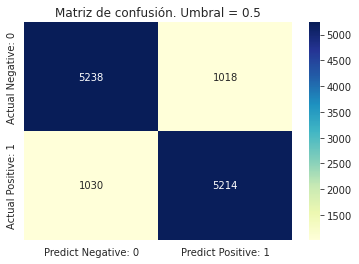

In [61]:
conf_mat(y_test, y_pred)

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      6256
           1       0.84      0.84      0.84      6244

    accuracy                           0.84     12500
   macro avg       0.84      0.84      0.84     12500
weighted avg       0.84      0.84      0.84     12500

